In [1]:
from __future__ import print_function, division
# import mdtraj as md
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
# from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
# from mdtraj.geometry import _geometry
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
from itertools import groupby
#from matplotlib import
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


2.2.2


In [2]:
dmat = np.load("distance_matrix_full_FAS.npy")

In [3]:
def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

In [4]:
print(dmat.shape)
# events_all = combined_residence_events(dmat)
# event = events_all[0]
# test = np.mean(dmat[event[0]:event[-1]+1], axis=0)

# print(test.shape)

(1110889, 20)


In [5]:

events_all = combined_residence_events(dmat)
mapping = np.zeros(len(events_all))
avg = np.zeros([len(events_all), len(dmat[0,:])])
print(avg.shape)
print(len(events_all))
print(len(mapping))


count = 0
for event in events_all:
  mapping[count] = len(event)
  avg[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  count += 1
  
print(avg[-1])

plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

print("Longest five events:", plotevents[:5])

    

(48714, 20)
48714
48714
[0.77049083 0.42704806 0.39055458 0.77061015 0.93264657 1.08730614
 1.48832214 1.64624655 1.74461901 1.71733999 1.91163409 1.84783232
 1.60522509 1.8416611  1.7956835  1.80895948 2.22302914 2.28145671
 2.20864868 2.66099954]
Longest five events: [1879 1326 1172 1086 1004]


[1879 1326 1172 1086 1004  979  969  956  936  903  899  844  831  831
  813  810  804  802  799  783]


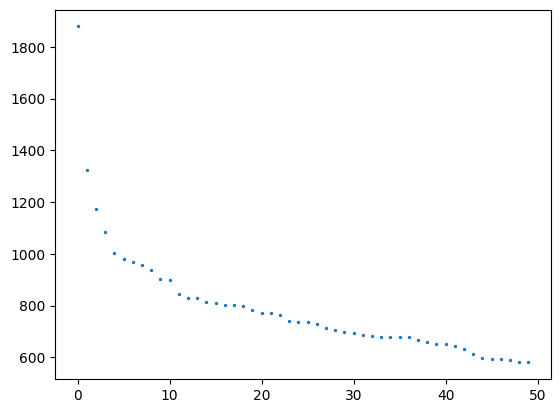

In [6]:
plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
ploteventsintime = np.array([len(i) for i in events_all])

plt.scatter(np.arange(50), plotevents[:50], s = 2)
print(plotevents[:20])

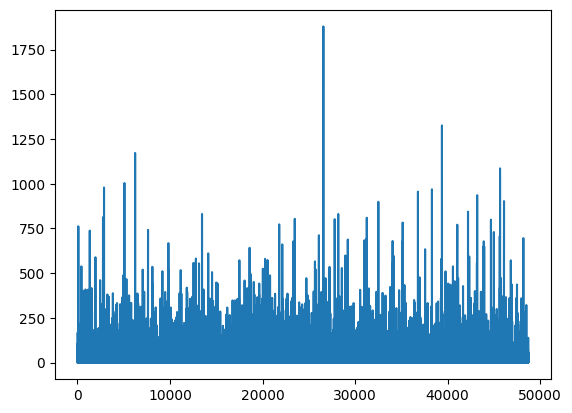

In [7]:
plt.plot(ploteventsintime)

In [8]:
# std = np.std(mapping)
# mean = np.mean(mapping)
# print(std, mean)
# mapping = (mapping - mean)/std
# print(mapping)

print(np.max(mapping))
print(np.min(mapping))
logmapping =  np.log(mapping)

# std = np.std(logmapping)
# mean = np.mean(logmapping)
# print(std, mean)
# logmapping = (logmapping - mean)/std


# print(logmapping)

# print(np.mean(dmat, 0))
# print(np.std(dmat, 0))

amean = np.mean(avg, 0)
astd = np.std(avg, 0)

avg = (avg - amean)/astd

1879.0
1.0


In [9]:
inputs = torch.from_numpy(avg)
inputs = torch.tensor(inputs, dtype=torch.float32)
print(inputs.shape)
print(inputs)
targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
targets = torch.tensor(targets, dtype=torch.float32)
# targets = targets.type(torch.LongTensor)
print(targets.shape)
print(targets)
dataset = TensorDataset(inputs, targets)


N = len(dataset)
indices = np.arange(N)
indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.85*N)]
test_indices = indices[int(0.85*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

batch_size = 64
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size)
test_dataloader = DataLoader(test_set, batch_size)

torch.Size([48714, 20])
tensor([[-0.6380, -0.8123, -1.0792,  ...,  0.7158,  0.5282,  0.4391],
        [-0.5381, -0.2016, -0.6332,  ...,  0.5707,  1.2277,  1.2474],
        [-0.5101, -0.5003,  0.0118,  ..., -0.3083,  0.4743,  0.6401],
        ...,
        [-0.5385, -0.0926,  0.2237,  ..., -0.0900,  0.3128,  0.4159],
        [-0.2993, -0.6527, -0.9757,  ...,  0.4303,  0.5776,  0.9575],
        [-1.2879, -1.8787, -1.7986,  ...,  1.6409,  1.4831,  2.0545]])
torch.Size([48714, 1])
tensor([[4.1431],
        [2.1972],
        [0.6931],
        ...,
        [3.8918],
        [2.5649],
        [1.0986]])
34099
[ 8768 30514 32491 ... 40744 20780  4543]
7307
[42604 38004 35736 ... 36824 32311 29171]
7308
[38902 24953 37643 ... 22856 33397 27389]


/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_81001/810009907.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_81001/810009907.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Linear(20, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                           weight_decay=0.001)


In [11]:
def train_model(model, optimizer, num_epochs=25):

    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join("tmp_ckpts", 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_loss = 999999

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_len
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader
                dataset_size = val_len

            running_loss = 0.0

            all_labels = []
            all_preds = []

            # Iterate over data.
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    logits = model(inputs)
                    loss = F.mse_loss(logits, labels, reduction='mean')
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                all_preds.append(logits)
                all_labels.append(labels.squeeze(1))


            epoch_loss = running_loss / dataset_size
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)
            # epoch_acc = accuracy_score(all_labels, all_preds)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            # print(phase, "Confusion matrix:")
            # print(confusion_matrix(all_labels, all_preds))
            
            print()

            # deep copy the model
            if phase == 'val' and epoch_loss > best_loss:
                best_loss = epoch_loss
                torch.save(model.state_dict(), best_model_params_path)

        print()
        
    # print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    # model.load_state_dict(torch.load(best_model_params_path))
    return model, all_preds, all_labels

In [12]:
trained_model, ap, al = train_model(model, optimizer, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.9656

val Loss: 0.7137


Epoch 1/19
----------
train Loss: 0.6587

val Loss: 0.5525


Epoch 2/19
----------
train Loss: 0.5831

val Loss: 0.5086


Epoch 3/19
----------
train Loss: 0.5450

val Loss: 0.4999


Epoch 4/19
----------
train Loss: 0.5203

val Loss: 0.5102


Epoch 5/19
----------
train Loss: 0.5072

val Loss: 0.4949


Epoch 6/19
----------
train Loss: 0.4950

val Loss: 0.4658


Epoch 7/19
----------
train Loss: 0.4874

val Loss: 0.4761


Epoch 8/19
----------
train Loss: 0.4746

val Loss: 0.4746


Epoch 9/19
----------
train Loss: 0.4700

val Loss: 0.4589


Epoch 10/19
----------
train Loss: 0.4668

val Loss: 0.4414


Epoch 11/19
----------
train Loss: 0.4568

val Loss: 0.4502


Epoch 12/19
----------
train Loss: 0.4536

val Loss: 0.4634


Epoch 13/19
----------
train Loss: 0.4531

val Loss: 0.4347


Epoch 14/19
----------
train Loss: 0.4496

val Loss: 0.4578


Epoch 15/19
----------
train Loss: 0.4499

val Loss: 0.4382


Epoch 16/19
------

In [13]:
print(torch.mean(ap))
print(torch.mean(al))

ap = torch.exp(ap)
al = torch.exp(al)

print(torch.mean(ap))
print(torch.mean(al))


tensor(1.3671)
tensor(1.3862)
tensor(14.0994)
tensor(17.1575)


In [14]:
al = torch.Tensor.numpy(al, force=True)
ap = torch.Tensor.numpy(ap, force=True)

In [15]:
top = (-ap).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap[index], "real:", al[index])

predicted [[1106.476]] real: [396.00006]
predicted [[758.7381]] real: [650.0001]
predicted [[627.96405]] real: [284.00006]
predicted [[458.75278]] real: [235.00003]
predicted [[441.78534]] real: [803.9998]
predicted [[433.81824]] real: [41.]
predicted [[393.54068]] real: [588.99994]
predicted [[372.02838]] real: [394.99997]
predicted [[358.25793]] real: [581.99994]
predicted [[357.8448]] real: [610.9999]
predicted [[344.41437]] real: [813.0001]
predicted [[338.73212]] real: [433.9999]
predicted [[333.62436]] real: [358.99994]
predicted [[329.16428]] real: [251.99997]
predicted [[312.27823]] real: [243.99995]
predicted [[312.22076]] real: [360.99997]
predicted [[310.0139]] real: [370.00006]
predicted [[308.58563]] real: [125.999985]
predicted [[298.6058]] real: [307.99997]
predicted [[296.7155]] real: [409.00006]


In [16]:
def test_model(model):
    model.eval()
    dataloader = test_dataloader
    dataset_size = test_len
    running_loss = 0.0
            
    all_labels= []
    all_preds= []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model(inputs)
        loss = F.mse_loss(logits, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        all_preds.append(logits)
        all_labels.append(labels)


    epoch_loss = running_loss / dataset_size
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {epoch_loss:.4f}')
    
    return all_preds, all_labels



In [17]:
ap2, al2 = test_model(trained_model)

Test Loss: 0.4387


In [18]:
print(torch.mean(ap2))
print(torch.mean(al2))

# ap2= (ap2*std) + mean
# al2= (al2*std) + mean

ap2 = torch.exp(ap2)
al2 = torch.exp(al2)

print(torch.mean(ap2))
print(torch.mean(al2))

al2 = torch.Tensor.numpy(al2, force=True)
ap2 = torch.Tensor.numpy(ap2, force=True)

tensor(1.3715, grad_fn=<MeanBackward0>)
tensor(1.3814)
tensor(13.6997, grad_fn=<MeanBackward0>)
tensor(16.7432)


In [19]:
top = (-al2).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[114.61821]] real: [[979.0002]]
predicted [[457.9474]] real: [[903.0001]]
predicted [[118.24931]] real: [[801.99994]]
predicted [[996.3708]] real: [[783.]]
predicted [[427.20557]] real: [[736.]]
predicted [[342.59708]] real: [[679.0001]]
predicted [[325.69073]] real: [[559.]]
predicted [[156.71518]] real: [[510.00003]]
predicted [[318.45346]] real: [[506.00003]]
predicted [[160.70215]] real: [[472.00006]]
predicted [[131.20418]] real: [[419.]]
predicted [[201.59314]] real: [[418.]]
predicted [[193.75887]] real: [[396.00006]]
predicted [[172.06421]] real: [[384.99997]]
predicted [[115.328285]] real: [[381.00006]]
predicted [[177.84103]] real: [[376.00006]]
predicted [[311.04327]] real: [[371.]]
predicted [[167.77463]] real: [[365.99994]]
predicted [[406.96533]] real: [[363.00006]]
predicted [[120.53943]] real: [[363.00006]]


In [20]:
top = (-ap2).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[996.3708]] real: [[783.]]
predicted [[641.06384]] real: [[312.00006]]
predicted [[530.1452]] real: [[313.00006]]
predicted [[457.9474]] real: [[903.0001]]
predicted [[427.20557]] real: [[736.]]
predicted [[406.96533]] real: [[363.00006]]
predicted [[388.6054]] real: [[264.00003]]
predicted [[350.2404]] real: [[265.99994]]
predicted [[342.59708]] real: [[679.0001]]
predicted [[337.73846]] real: [[182.99997]]
predicted [[325.69073]] real: [[559.]]
predicted [[318.45346]] real: [[506.00003]]
predicted [[312.85562]] real: [[86.99999]]
predicted [[311.04327]] real: [[371.]]
predicted [[308.99554]] real: [[190.]]
predicted [[296.26437]] real: [[361.99994]]
predicted [[278.86594]] real: [[164.]]
predicted [[273.3542]] real: [[75.00001]]
predicted [[262.26614]] real: [[121.99998]]
predicted [[256.697]] real: [[245.00005]]


In [21]:
bottom = (ap2).argsort(axis=0)[:20]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[1.0339477]] real: [[1.]]
predicted [[1.0403681]] real: [[1.]]
predicted [[1.0472335]] real: [[1.]]
predicted [[1.0576333]] real: [[1.]]
predicted [[1.0594555]] real: [[1.]]
predicted [[1.0599757]] real: [[1.]]
predicted [[1.0613285]] real: [[1.]]
predicted [[1.0623628]] real: [[1.]]
predicted [[1.0625932]] real: [[1.]]
predicted [[1.0628669]] real: [[1.]]
predicted [[1.0644155]] real: [[1.]]
predicted [[1.065202]] real: [[1.]]
predicted [[1.0659037]] real: [[1.]]
predicted [[1.0662068]] real: [[1.]]
predicted [[1.0665319]] real: [[1.]]
predicted [[1.0665787]] real: [[1.]]
predicted [[1.067282]] real: [[1.]]
predicted [[1.0673187]] real: [[1.]]
predicted [[1.0675309]] real: [[1.]]
predicted [[1.0677693]] real: [[1.]]


r2: 0.8118140455660009


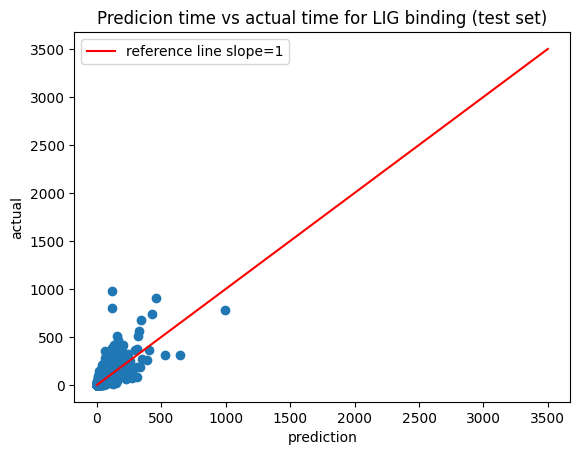

In [22]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 3500,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

r2: 0.8118140455660009


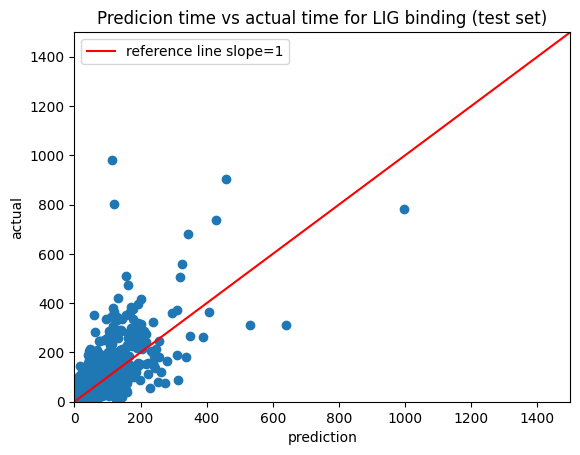

In [23]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 3500,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,1500])
plt.xlim([0,1500])
plt.show()

r2: 0.8118140455660009


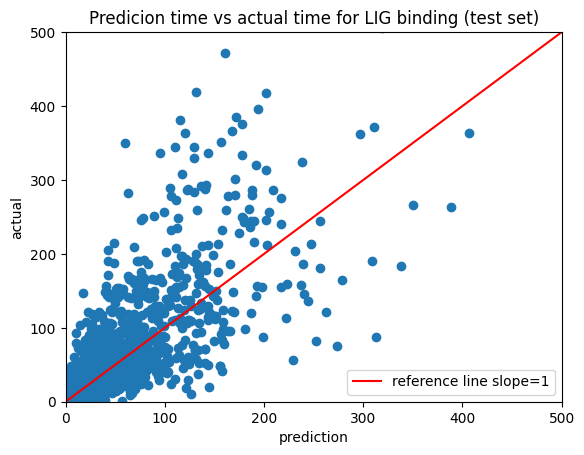

In [24]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 3500,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,500])
plt.xlim([0,500])
plt.show()

r2: 0.8118140455660009


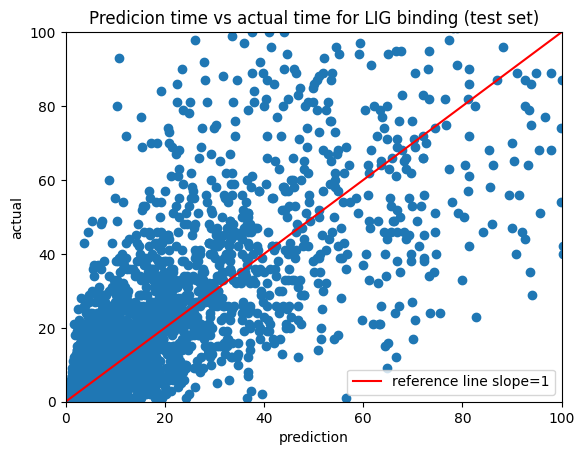

In [25]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 3500,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,100])
plt.xlim([0,100])
plt.show()

r2: 0.8118140455660009


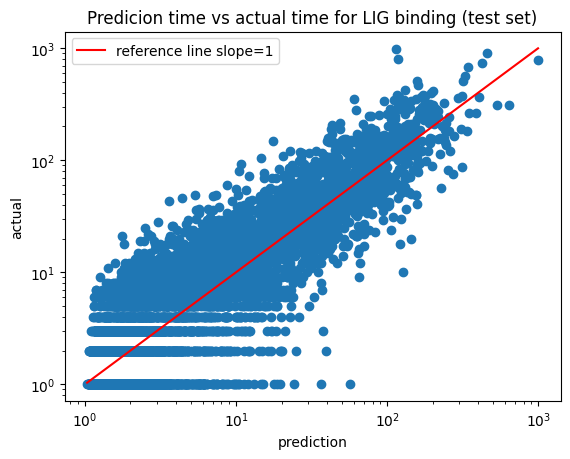

In [26]:
plt.scatter(ap2,al2)
plt.xscale("log")
plt.yscale("log")
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(min(ap2[:,0]), max(ap2[:,0]),20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()